# 0.0 Imports

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import streamlit as st
import inflection
import datetime
import math
from IPython.display import Image

## 0.1 Helper functions

## 0.2 Loading data

In [17]:
df_sales_raw = pd.read_csv('data\\train.csv', low_memory = False)
df_store_raw = pd.read_csv('data\\store.csv', low_memory = False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw,how = 'left', on ='Store')
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0 Descrição dos dados

In [18]:
df1 = df_raw.copy()

In [19]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list( map( snakecase, cols_old))

# rename

df1.columns = cols_new

## 1.1 Data dimension

In [20]:
print('Number of rows: ', df1.shape[0])
print('Number of columns: ', df1.shape[1])

Number of rows:  1017209
Number of columns:  18


## 1.2 Data types

In [21]:
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.3 Check NA

In [22]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.4 Fillout NA

In [23]:
df1['competition_distance'].max()

75860.0

In [24]:
# competition_distance              2642
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month    323348
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

# competition_open_since_year     323348
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

# promo2_since_week               508031
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

# promo2_since_year               508031
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)


In [26]:
# promo_interval                  508031
month_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug', 9:'Sept',10:'Oct',11:'Nov',12:'Dec'}
df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

In [27]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.5 Change Types

In [31]:
df1.dtypes

change_int = ['competition_open_since_month','competition_open_since_year','promo2_since_week','promo2_since_year']
for i in change_int:
    df1[i] = df1[i].astype('int64')

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.6 Descriptive Statistical

In [33]:
num_attributes = df1.select_dtypes(include = ['int64','float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64','float64','datetime64[ns]'])

### 1.6.1 Numerical Attributes

In [38]:
# central tendency - mean/median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std )).T
d2 = pd.DataFrame(num_attributes.apply(np.min )).T
d3 = pd.DataFrame(num_attributes.apply(np.max )).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\pedro\AppData\Local\Temp\ipykernel_3872\710812770.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['sales'])


<AxesSubplot:xlabel='sales', ylabel='Density'>

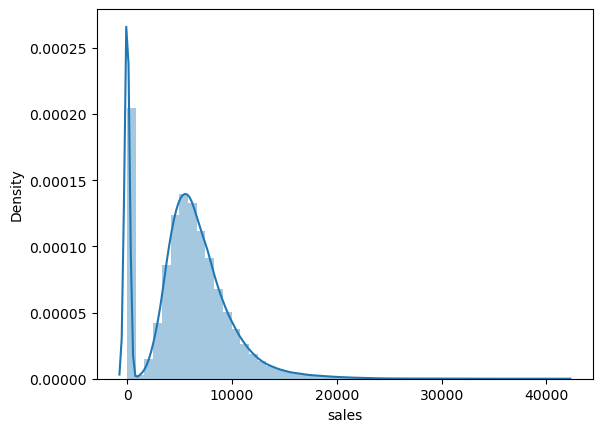

In [39]:
sns.distplot(df1['sales'])

### 1.6.2 Categorical attributes

In [40]:
cat_attributes.apply(lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

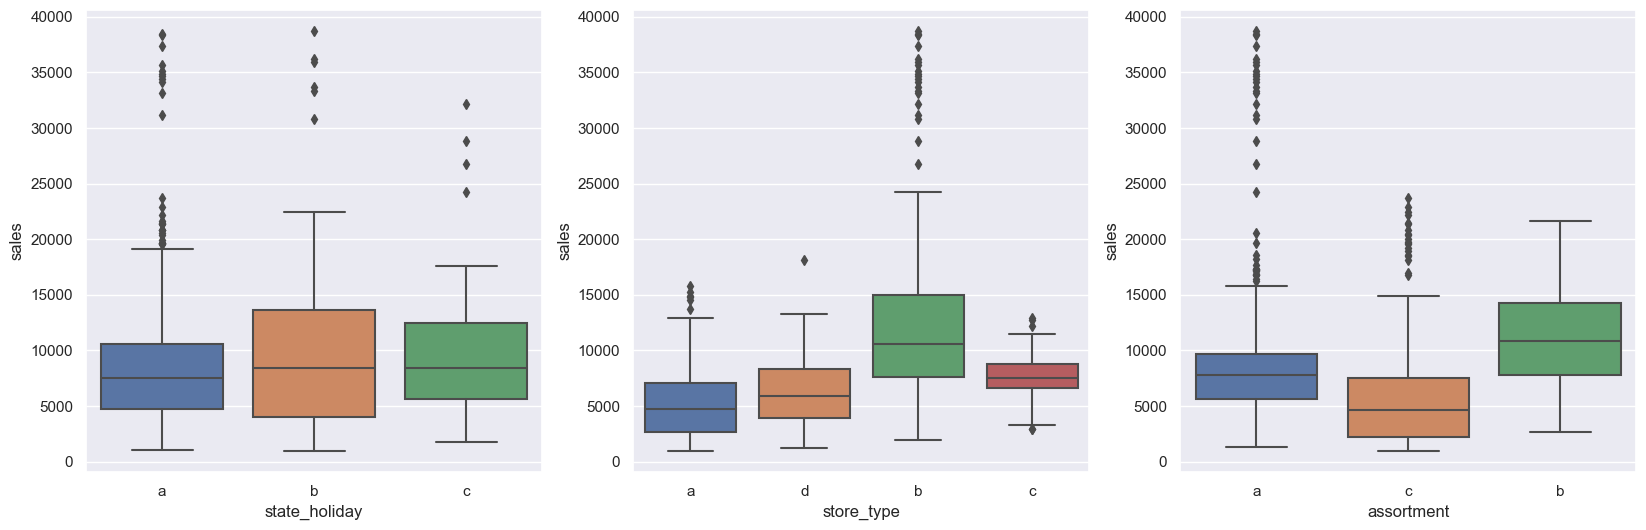

In [51]:
fig, axes = plt.subplots(1,3,figsize = (20,6))
sns.set()
aux1 = df1.loc[(df1['state_holiday'] != '0') & (df1['sales']> 0)]

sns.boxplot(x='state_holiday',y='sales', data=aux1, ax = axes[0])
sns.boxplot(x='store_type',y='sales', data=aux1, ax = axes[1])
sns.boxplot(x='assortment',y='sales', data=aux1, ax = axes[2])
plt.show()

# 2.0 Feature Engineering

## Mapa de hipoteses

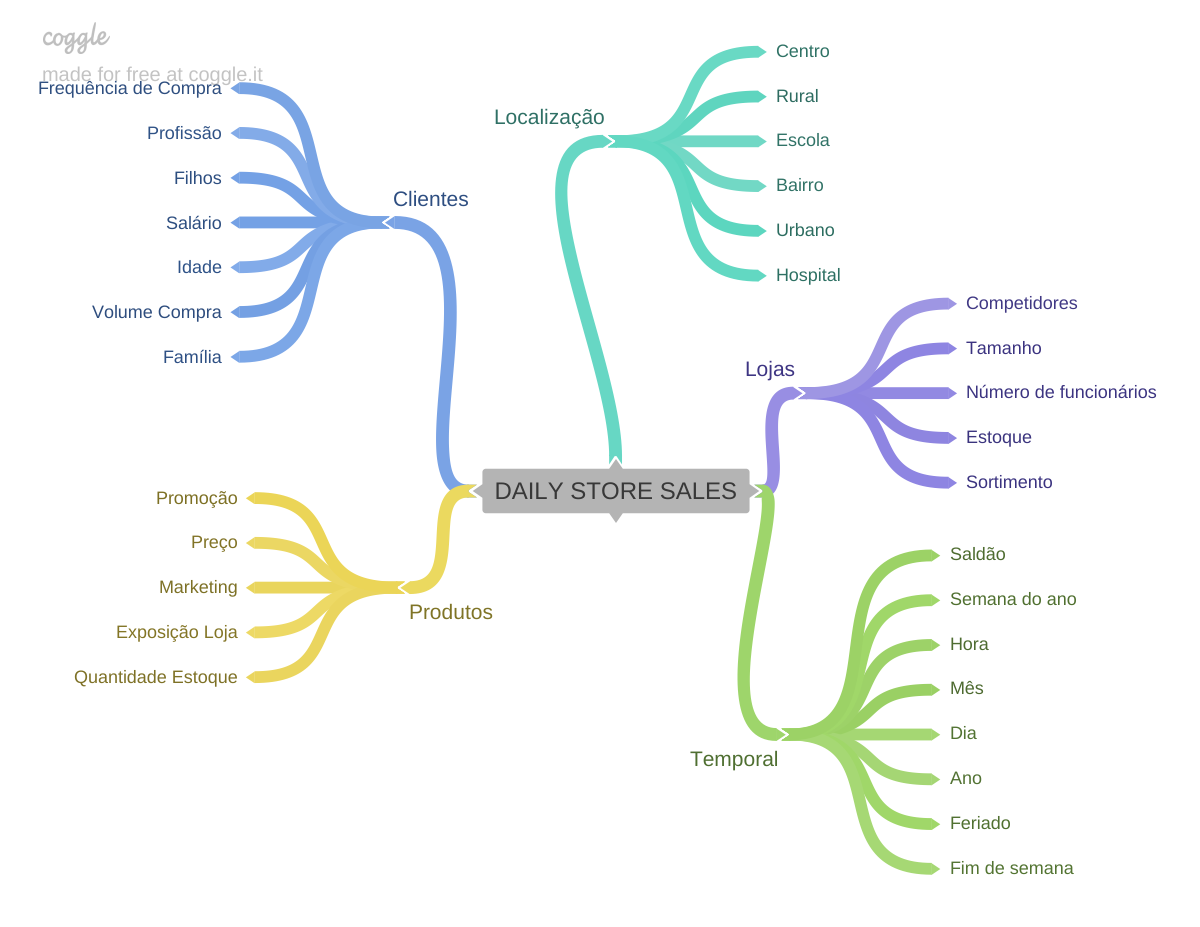

In [58]:
Image('img\\daily_store_sales.png', width = 800, height = 600)

## 2.1 Criação de hipoteses

### 2.1.0 Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.1.1 Hipoteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposição de produtos deveriam vender mais.

**3.** Lojas com produtos com preços menores deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.2 Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender menos.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante feriados escolares.


## 2.2 Lista Final de hipoteses

- Loja

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.


- Produto

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.


- Tempo

**7.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**8.** Lojas deveriam vender menos aos finais de semana.

**9.** Lojas deveriam vender menos durante feriados escolares.

## 2.3 Feature Engineering

In [64]:
# year
df1['year'] = df1['date'].dt.year

# month
df1['month'] = df1['date'].dt.month

#day
df1['day'] = df1['date'].dt.day

# week of year
df1['week_of_year'] = df1['date'].dt.weekofyear

# year week
df1['year_week'] = df1['date'].dt.strftime('%Y-%W')


# competition since
df1['competition_since'] = df1.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month =  x['competition_open_since_month'], day = 1), axis = 1)
df1['competition_time_month'] = ((df1['date'] - df1['competition_since']) / 30).apply(lambda x: x.days).astype('int64')

# promo since
df1['promo_since'] = df1['promo2_since_year'].astype(str) + '-' + df1['promo2_since_week'].astype(str)
df1['promo_since'] = df1['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))

df1['promo_time_week'] = ((df1['date'] - df1['promo_since']) / 7).apply(lambda x: x.days).astype('int64')

#assortment
df1['assortment'] = df1['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday
df1['state_holiday'] = df1['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 
                                                            'easter_holiday' if x == 'b' else 
                                                            'christmas' if x == 'c' else
                                                            'regular_day')


C:\Users\pedro\AppData\Local\Temp\ipykernel_3872\2813319398.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df1['week_of_year'] = df1['date'].dt.weekofyear


In [61]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,31,2015,0,Jul,0,2015,7,31,31,2015-30
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,31,2015,0,Jul,0,2015,7,31,31,2015-30
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,31,2015,0,Jul,0,2015,7,31,31,2015-30


# 3.0 Filtragem de variáveis

In [65]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das linhas

In [66]:
df1 = df1.loc[ (df1['open'] != 0) & (df1['sales'] > 0) ]


## 3.2 Seleção das colunas

In [67]:
cols_drop = ['customers','open','promo_interval','month_map']
df1.drop(cols_drop, axis = 1, inplace = True)

# 4.0 Análise Exploratória dos Dados

## 4.1 Análise univariada

### 4.1.1 Response variable

C:\Users\pedro\AppData\Local\Temp\ipykernel_3872\710812770.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['sales'])


<AxesSubplot:xlabel='sales', ylabel='Density'>

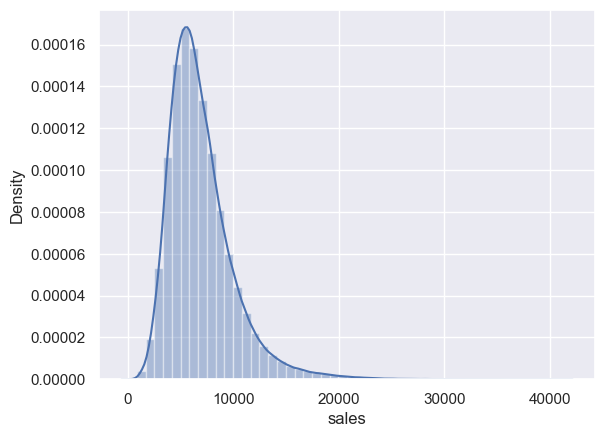

In [68]:
sns.distplot(df1['sales'])

### 4.1.2 Numerical variable

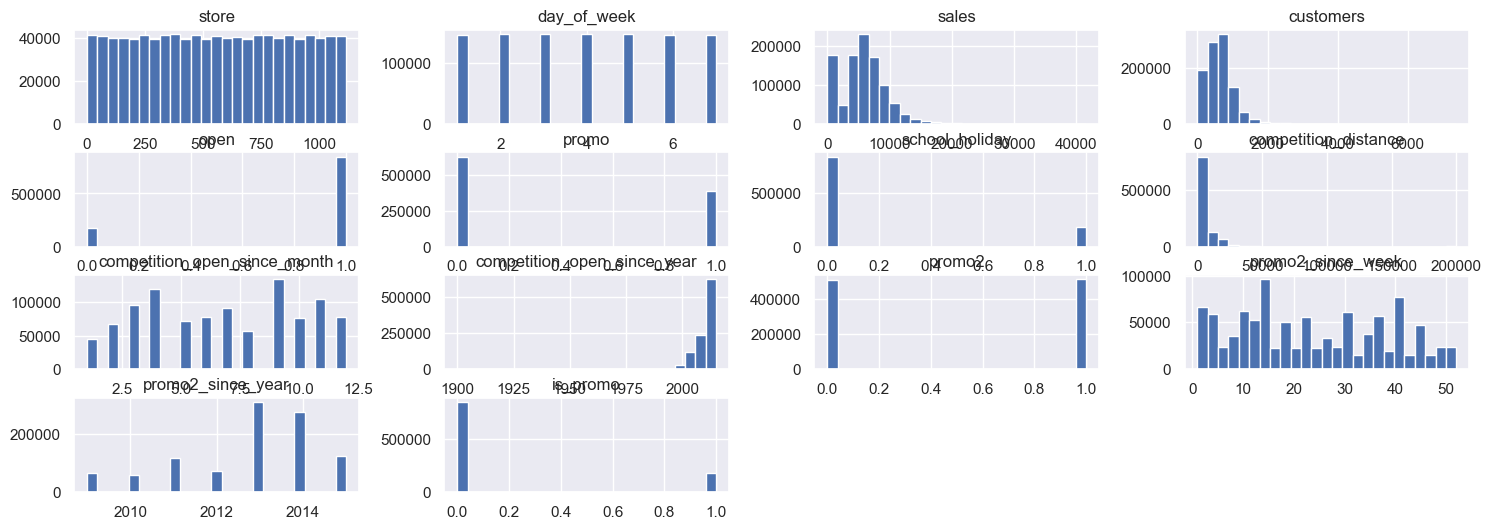

In [75]:
num_attributes.hist(figsize=(18,6), bins = 25);

### 4.1.3 Categorical variable

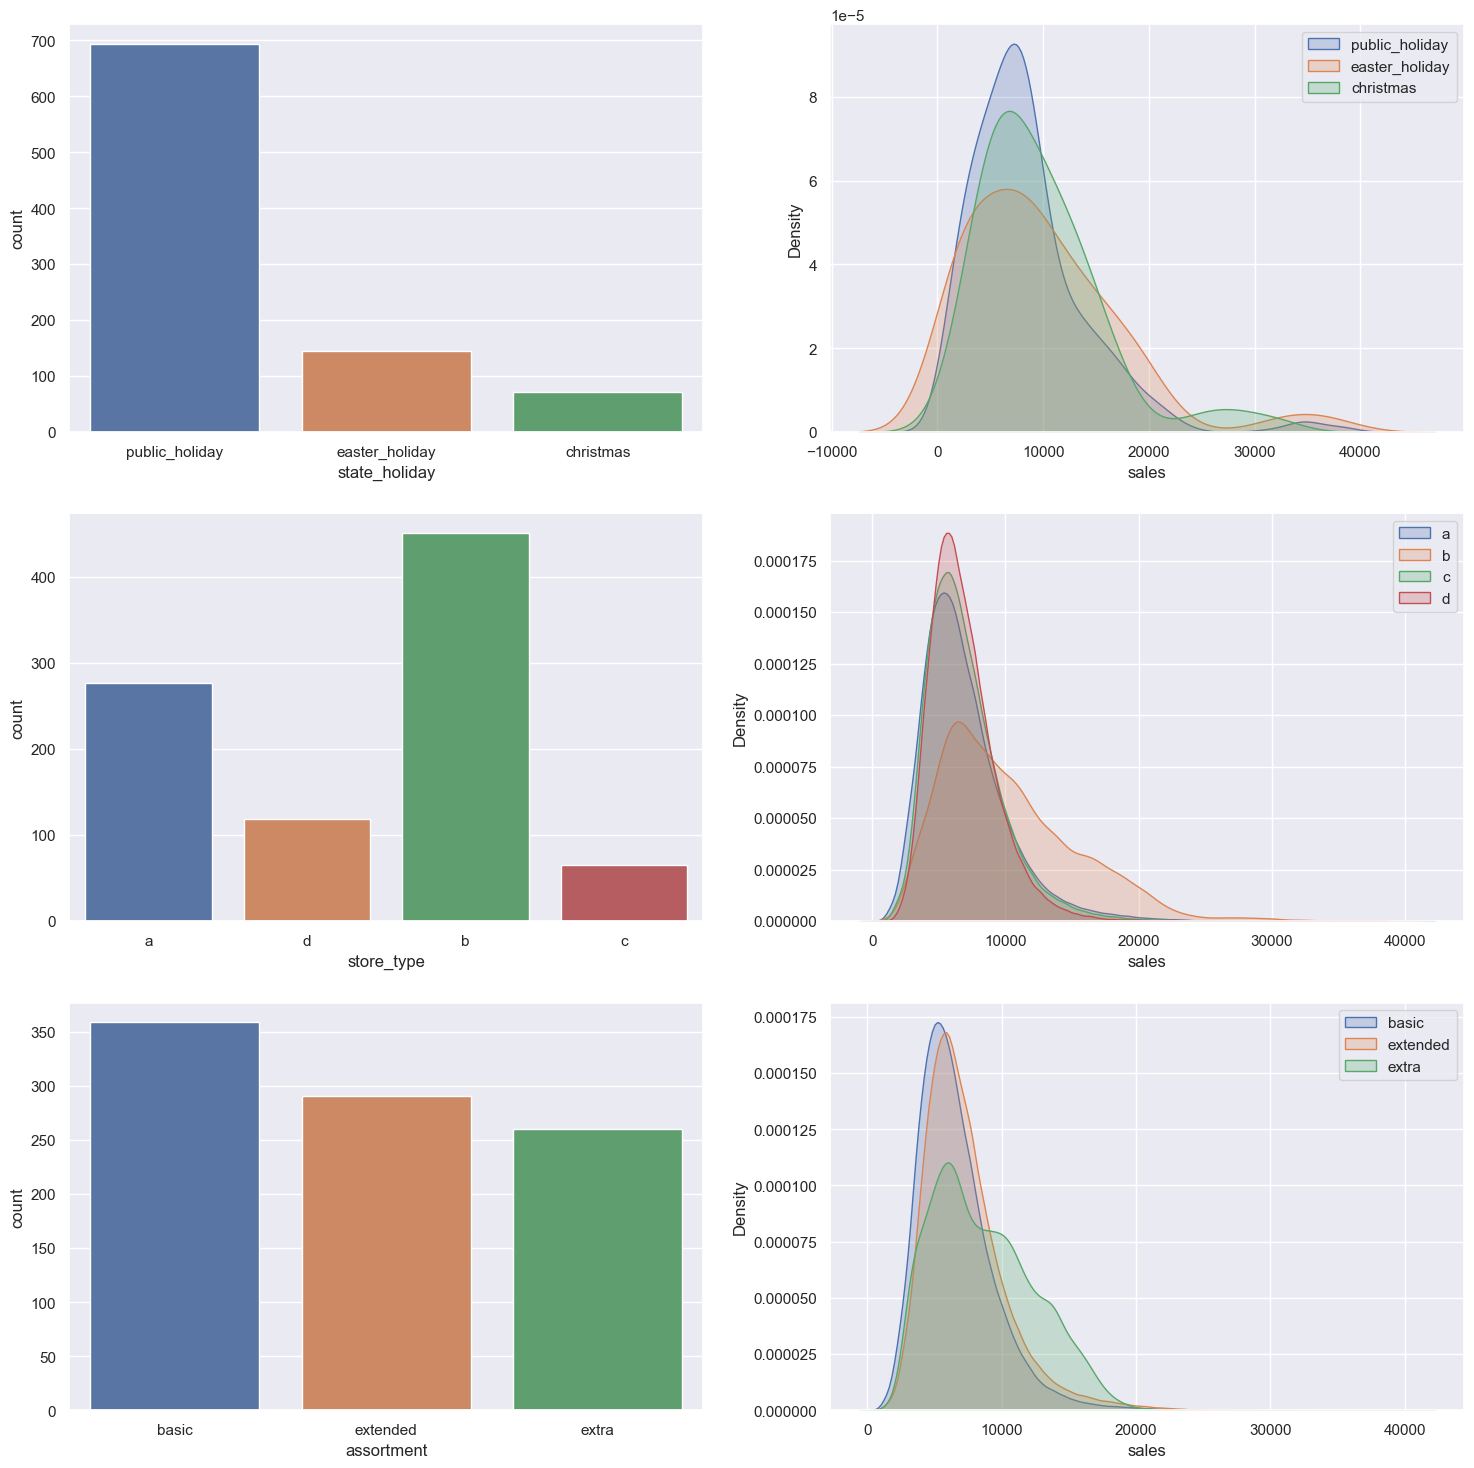

In [103]:
fig, axes = plt.subplots(3,2,figsize=(18,18))

# state holiday
a = df1[df1['state_holiday'] != 'regular_day']
sns.countplot(x=a['state_holiday'], ax = axes[0,0])

sns.kdeplot( df1[df1['state_holiday'] == 'public_holiday']['sales'], fill = True, label ='public_holiday', ax = axes[0,1], legend = True)
sns.kdeplot( df1[df1['state_holiday'] == 'easter_holiday']['sales'], fill = True, label ='easter_holiday', ax = axes[0,1], legend = True)
sns.kdeplot( df1[df1['state_holiday'] == 'christmas']['sales'], fill = True, label ='christmas', ax = axes[0,1], legend = True)

# store type
sns.countplot(x=a['store_type'], ax = axes[1,0])
sns.kdeplot( df1[df1['store_type'] == 'a']['sales'], fill = True, label ='a', ax = axes[1,1], legend = True)
sns.kdeplot( df1[df1['store_type'] == 'b']['sales'], fill = True, label ='b', ax = axes[1,1],legend = True)
sns.kdeplot( df1[df1['store_type'] == 'c']['sales'], fill = True, label ='c', ax = axes[1,1],legend = True)
sns.kdeplot( df1[df1['store_type'] == 'd']['sales'], fill = True, label ='d', ax = axes[1,1],legend = True)
axes[1,1].legend()
axes[0,1].legend()

# assortment
sns.countplot(x=a['assortment'], ax = axes[2,0])
sns.kdeplot( df1[df1['assortment'] == 'basic']['sales'], fill = True, label ='basic', ax = axes[2,1], legend = True)
sns.kdeplot( df1[df1['assortment'] == 'extended']['sales'], fill = True, label ='extended', ax = axes[2,1],legend = True)
sns.kdeplot( df1[df1['assortment'] == 'extra']['sales'], fill = True, label ='extra', ax = axes[2,1],legend = True)
axes[2,1].legend()

## 4.2 Análise bivariada

### H1 Lojas com maior sortimento deveriam vender mais

**FALSA** lojas com MAIOR sortimento, vendem MENOS.

<AxesSubplot:xlabel='year_week'>

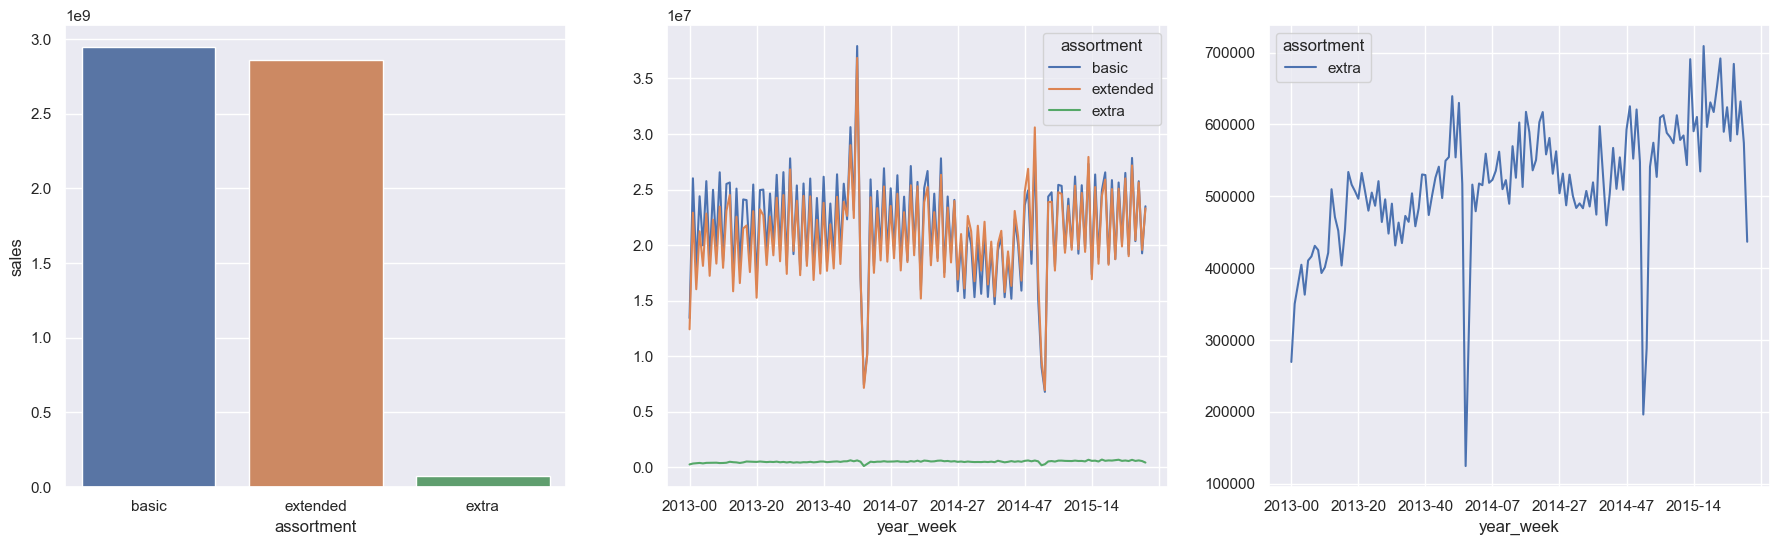

In [113]:
fig, axes = plt.subplots(1,3,figsize = (22,6))
aux1 = df1[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y ='sales', data = aux1, ax = axes[0])


aux2 = df1[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum(). reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot(ax= axes[1])


aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot(ax = axes[2])

### H2 Lojas com competidores mais próximos deveriam vender menos

**FALSA** Lojas com competidores mais próximos, vendem mais

In [126]:
# aux1 = df1[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

# sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1)

C:\Users\pedro\AppData\Local\Temp\ipykernel_3872\988699742.py:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(aux1.corr(method = 'pearson'), annot = True, ax = axes[1,0]);


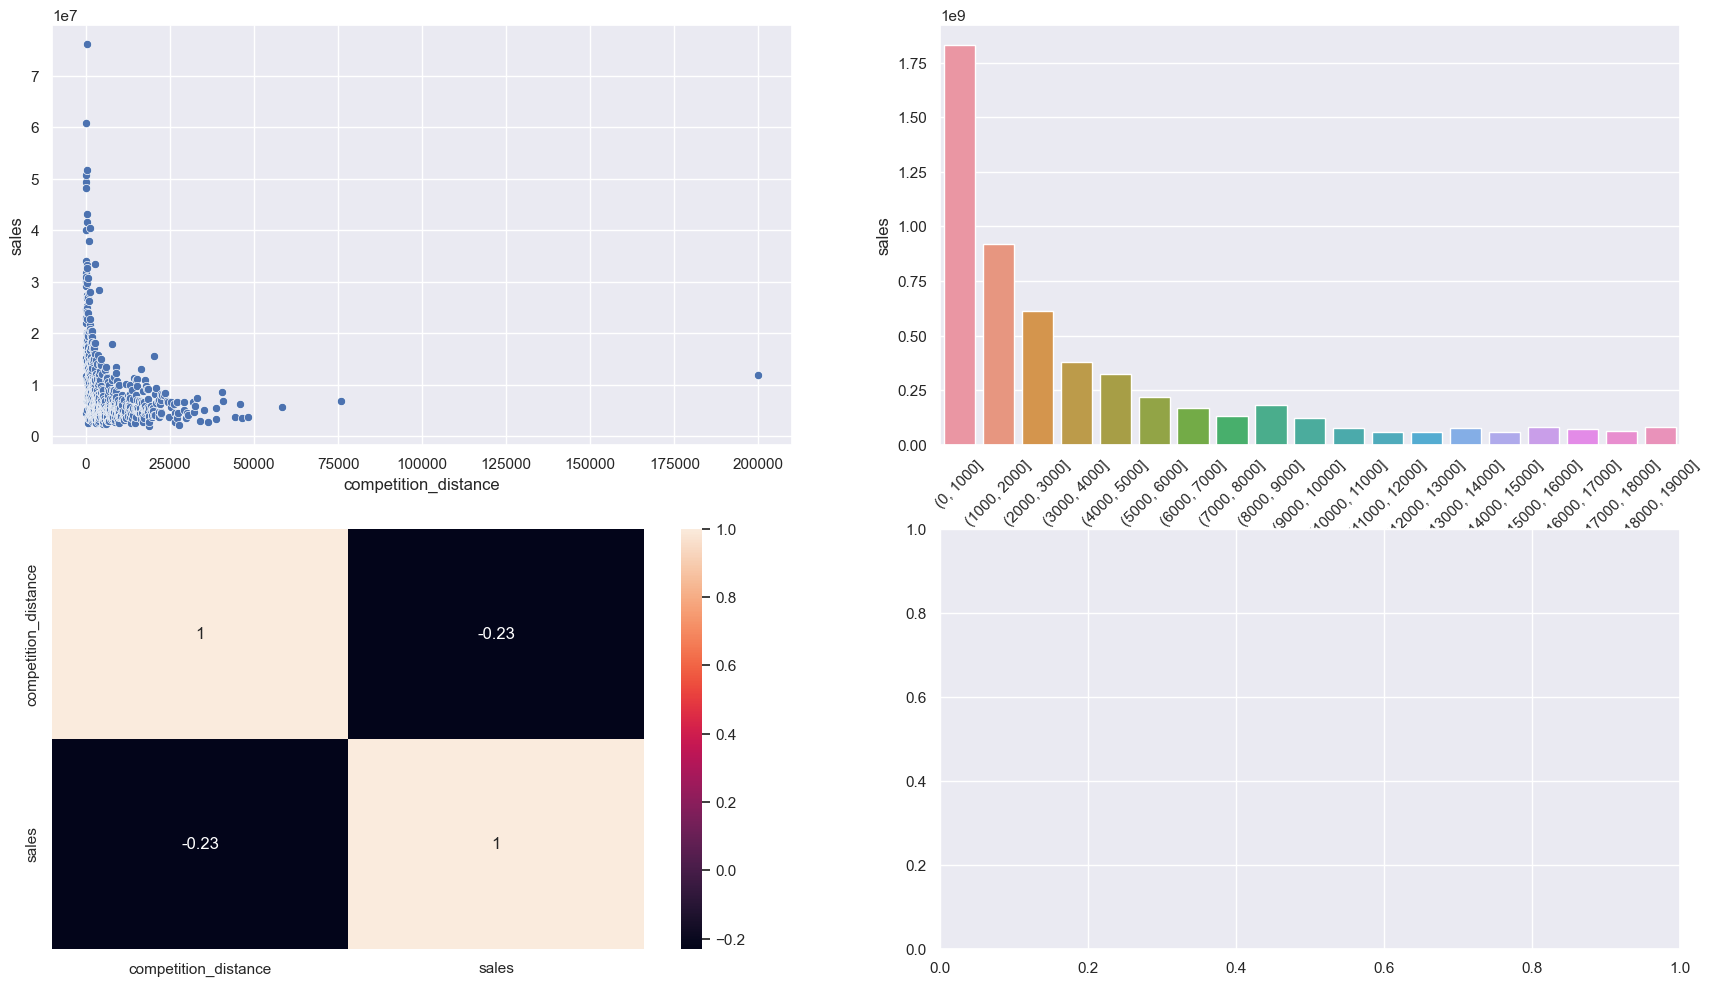

In [129]:
fig, axes = plt.subplots(2,2,figsize = (21,12))
aux1 = df1[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1, ax = axes[0,0]);


bins = list(np.arange(0, 20000,1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1.groupby(['competition_distance_binned'], as_index = False)['sales'].sum()
sns.barplot(x = 'competition_distance_binned', y= 'sales', data = aux2, ax = axes[0,1]);
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45);

sns.heatmap(aux1.corr(method = 'pearson'), annot = True, ax = axes[1,0]);

### H3 Lojas com competidores a mais tempo deveriam vender mais

**FALSA** Lojas com competidores a mais tempo vendem menos

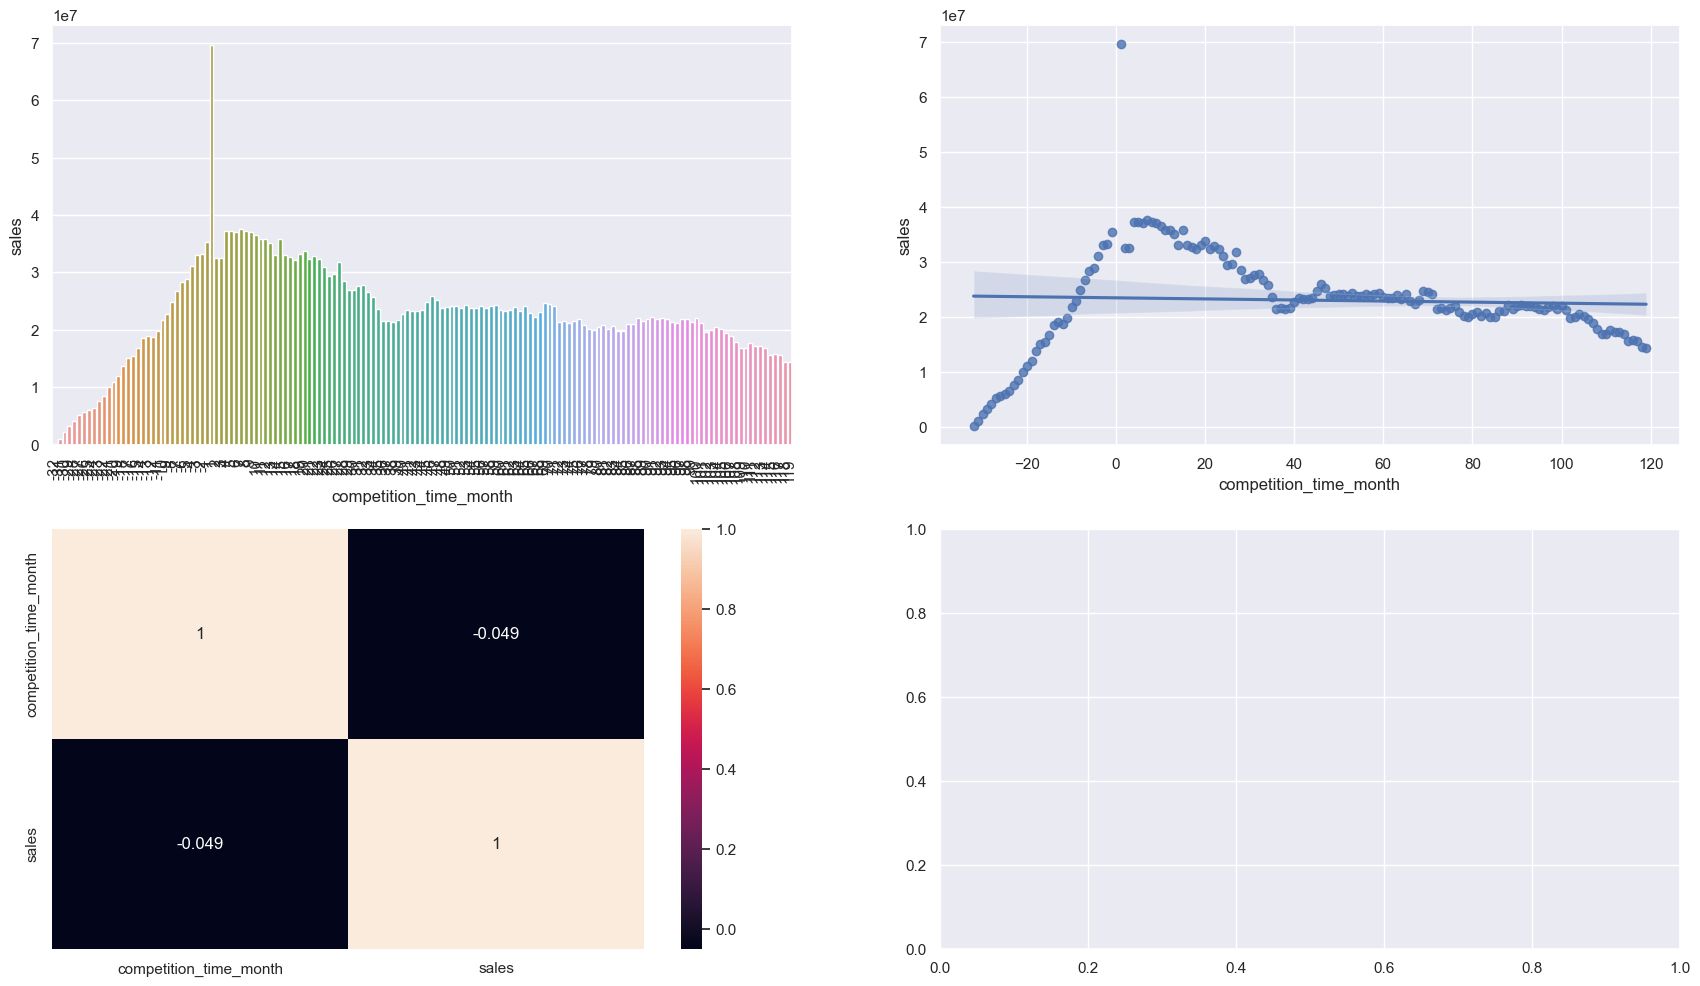

In [143]:
fig, axes = plt.subplots(2,2,figsize = (21,12))

aux1 = df1[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()

aux2 = aux1.loc[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2, ax = axes[0,0]);
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation = 90);


sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2, ax = axes[0,1]);

sns.heatmap(aux2.corr(method = 'pearson'), annot = True, ax = axes[1,0]);

## 4.3 Análise multivariada